# EDA – Exploratory Data Analysis

In diesem Notebook wird die explorative Datenanalyse (EDA) durchgeführt. Ziel ist es, ein grundlegendes Verständnis für die Daten zu gewinnen, potenzielle Probleme wie Ausreißer oder fehlende Werte zu identifizieren.

Die EDA basiert auf einer gereinigten Version des Datensatzes, die in einem separaten Notebook (`0_data_cleaning.ipynb`) erzeugt wurde.

📌 **Datenstand:** `cleaned_data.csv`  
📁 **Importiert aus:** lokaler Datei (--> gitignore)

## 📚 Inhaltsverzeichnis 
(Diese Art von Inhaltsverzeichnis mit Link funktioniert leider in Notebooks nicht, weil die as JSON gespeichert werden und nicht als HTML...)

- [0. Datensatz laden](#0-datensatz-laden)
- [1. Überblick über den Datensatz](#1-überblick-über-den-datensatz)
- [2. Schadstoffe – Deskriptive Statistik & Ausreißer](#2-deskriptive-statistik--ausreisser-handling-schadstoffe)
  - [2.1 Mittelgroße Feinstaubpartikel (PM25)](#21-mittelgroße-feinstaubpartikel-pm25)
  - [2.2 Große Feinstaubpartikel (PM10)](#22-große-feinstaubpartikel-pm10)
  - [2.3 Kohlenmonoxid (CO)](#23-kohlenmonoxid-co)
  - [2.4 Stickstoffdioxid (NO2)](#24-stickstoffdioxid-no2)
  - [2.5 Schwefeldioxid (SO2)](#25-schwefeldioxid-so2)
  - [2.6 Ozon (O3)](#26-ozon-o3)
  - [2.7 Anzahl der entfernten Werte](#27-tabelle-zur-anzahl-der-entfernten-werte-pro-spalte)
- [3. Wetter – Deskriptive Statistik & Ausreißer](#3-deskriptive-statistik--ausreisser-handling-wetter)
- [4. Speichern des ausreißerbereinigten Datensatzes](#4-speichern-des-ausreisserbereinigten-datensatzes)


# 0. Datensatz laden

In [ ]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from datetime import date
%matplotlib inline

In [11]:
# Settings for displaying floats
pd.set_option('display.float_format', '{:,.2f}'.format)

In [12]:
df = pd.read_csv("./data/cleaned_data.csv")
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2019,2,28,SA,Abha,18.22,42.51,"5,616,633.00",NaN,NaN,...,NaN,6.00,45.00,18.80,15.80,24.10,NaN,183.00,21.90,"1,022.30"
1,2019,3,1,SA,Abha,18.22,42.51,"5,616,633.00",NaN,NaN,...,NaN,12.00,64.00,17.00,13.50,23.00,NaN,185.00,21.20,"1,021.90"
2,2019,3,2,SA,Abha,18.22,42.51,"5,616,633.00",NaN,0.00,...,0.00,9.00,63.00,16.70,10.80,23.60,NaN,186.00,15.20,"1,022.30"
3,2019,3,3,SA,Abha,18.22,42.51,"5,616,633.00",NaN,0.00,...,0.00,6.00,55.00,15.90,10.80,22.00,NaN,196.00,16.50,"1,023.40"
4,2019,3,4,SA,Abha,18.22,42.51,"5,616,633.00",NaN,0.00,...,0.00,3.00,58.00,16.10,9.00,22.50,NaN,NaN,11.20,"1,023.80"


In [13]:
# Überblick
print(f"Anzahl Zeilen: {df.shape[0]:,}")
print(f"Anzahl Spalten: {df.shape[1]}")
df.head()


Anzahl Zeilen: 1,695,041
Anzahl Spalten: 23


,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2019,2,28,SA,Abha,18.22,42.51,"5,616,633.00",NaN,NaN,...,NaN,6.00,45.00,18.80,15.80,24.10,NaN,183.00,21.90,"1,022.30"
1,2019,3,1,SA,Abha,18.22,42.51,"5,616,633.00",NaN,NaN,...,NaN,12.00,64.00,17.00,13.50,23.00,NaN,185.00,21.20,"1,021.90"
2,2019,3,2,SA,Abha,18.22,42.51,"5,616,633.00",NaN,0.00,...,0.00,9.00,63.00,16.70,10.80,23.60,NaN,186.00,15.20,"1,022.30"
3,2019,3,3,SA,Abha,18.22,42.51,"5,616,633.00",NaN,0.00,...,0.00,6.00,55.00,15.90,10.80,22.00,NaN,196.00,16.50,"1,023.40"
4,2019,3,4,SA,Abha,18.22,42.51,"5,616,633.00",NaN,0.00,...,0.00,3.00,58.00,16.10,9.00,22.50,NaN,NaN,11.20,"1,023.80"


# 1. Überblick über den Datensatz

- Überblicksfunktion .overview()
- Fehlende Werte ausloten und, wenn vorhanden, Spalten mit < 50% Daten entfernen.

In [14]:
# Function to create overview for dtypes, missing values, unique values

def overview(df):
    '''
    Erstelle einen Überblick über einige Eigenschaften der Spalten eines DataFrames.
    VARs
        df: Der zu betrachtende DataFrame
    RETURNS:
        None
    '''
    display(pd.DataFrame({'dtype': df.dtypes,
                          'total': df.count(),
                          'missing': df.isna().sum(),
                          'missing%': df.isna().mean()*100,
                          'n_uniques': df.nunique(),
                          'uniques%': df.nunique()/df.shape[0]*100,
                          'uniques': [df[col].unique() for col in df.columns]
                         }))


In [15]:
overview(df)

,dtype,total,missing,missing%,n_uniques,uniques%,uniques
Year,int64,1695041,0,0.00,12,0.00,"[2019, 2020, 2021, 2022, 2023, 2024, 2025, 201..."
Month,int64,1695041,0,0.00,12,0.00,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1]"
Day,int64,1695041,0,0.00,31,0.00,"[28, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
Country,object,1695041,0,0.00,95,0.01,"[SA, CI, AE, GH, TR, ET, AU, MX, JP, US, DZ, K..."
City,object,1695041,0,0.00,616,0.04,"[Abha, Abidjan, Abu dhabi, Accra, Adana, Adapa..."
Latitude,float64,1692212,2829,0.17,617,0.04,"[18.21639, 5.35444, 24.45118, 5.55602, 36.9861..."
Longitude,float64,1692212,2829,0.17,616,0.04,"[42.50528, -4.00167, 54.39696, -0.1969, 35.325..."
Population,float64,1682144,12897,0.76,1289,0.08,"[5616633.0, 2263373.0, 1276701.0, 1288681.0, 1..."
Co,float64,1063231,631810,37.27,1009,0.06,"[nan, 0.0, 15.0, 13.0, 10.0, 7.0, 9.0, 6.0, 5...."
No2,float64,1408781,286260,16.89,1291,0.08,"[nan, 0.0, 9.0, 6.0, 5.0, 7.0, 4.0, 2.0, 3.0, ..."


In [16]:
# Sort missing values (descending)

missing_percent = df.isna().mean() * 100
missing_percent_sorted = missing_percent.sort_values(ascending=False)

print(missing_percent_sorted)

Dew          40.99
Prcp         38.57
Co           37.27
So2          31.44
Wdir         30.92
Pres         28.95
Wspd         26.83
Humidity     22.90
O3           22.07
Pm10         20.17
Tmax         18.77
Tmin         18.67
Tavg         17.19
No2          16.89
Pm25         15.50
Population    0.76
Longitude     0.17
Latitude      0.17
Month         0.00
City          0.00
Country       0.00
Day           0.00
Year          0.00
dtype: float64


In [ ]:
# Optional: Spalten mit >50% fehlenden Werten entfernen.
# (Der aktuelle Datensatz ist vollständig genug – daher ist dieser Schritt derzeit nicht notwendig.)

# # Remove all columns with more than 50% missing values

# # Store number of columns before removing
# original_columns = df.shape[1]

# df = df.loc[:, missing_percent <= 50]

# # Print what has changed
# print(f"Anzahl der entfernten Spalten: {original_columns - df.shape[1]}")
# removed = missing_percent[missing_percent > 50].index
# print("Entfernte Spalten:", list(removed))
# print("Übrige Spalten:", df.columns)

# df.shape

# 2. Deskriptive Statistik & Ausreißer-Handling: Schadstoffe

Vor der systematischen Ausreißeranalyse ist es sinnvoll, kurz die Art der Daten zu reflektieren:
Wetterdaten (wie Temperatur, Luftdruck oder Windgeschwindigkeit) werden seit Jahrzehnten weltweit standardisiert erfasst. Die verwendeten Messinstrumente sind technisch ausgereift, gut kalibriert und liefern in der Regel konsistente Ergebnisse. Aus diesem Grund ist hier nur mit wenigen Ausreißern oder Platzhalterwerten zu rechnen.

Bei Schadstoffmessungen (wie PM₂.₅, NO₂ oder O₃) sieht die Situation anders aus. Diese Daten werden häufig mit komplexeren Sensoren erhoben, die empfindlicher auf Umwelteinflüsse oder Wartungsprobleme reagieren. Außerdem sind Schadstoffmessstationen nicht flächendeckend verfügbar, was zu uneinheitlicher Datenqualität führen kann. In der Praxis zeigt sich das häufig durch auffällige Ausreißerwerte oder symbolische Platzhalter wie 500 oder 999, die als Maximalwert oder Fehlwert dienen.

Auf Basis dieser Überlegungen erwarten wir bei der folgenden Analyse:

- Mehr auffällige Werte in den Schadstoffvariablen
- Weniger (aber nicht zwingend keine) Ausreißer bei den Wetterdaten

Diese Hypothese bestätigt sich auch in der Auswertung.

Entsprechend dieser Erwartung wurde das methodische Vorgehen angepasst:

- Die Schadstoffvariablen wurden einzeln analysiert – mit Stripplots, Schiefe-Werten und einer individuellen Beurteilung der Ausreißerstruktur.

- Bei den Wettervariablen wurde – unter Berücksichtigung ihrer geringeren Anfälligkeit für Messfehler – eine automatisierte Analyse mittels Schleife durchgeführt, die Kennzahlen berechnet und visualisiert, um dennoch potenzielle Ausreißer strukturiert erkennen und ggf. entfernen zu können.

Die Entscheidungen, wo jeweils der Schwellenwert für die Ausreißerentfernung gesetzt wird, sind nicht rein statistisch begründet (z.B. 99,99-Quantil als Cutoff), sondern werden für jedes Feature individuell getroffen. Ziel der Ausreißerentfernung ist es, sachlich unmögliche Werte zu entfernen, die natürliche Varianz zu erhalten und einen repräsentativen Datensatz für folgende Modellierungen zu schaffen.

Methode zur Ausreißerentfernung: Zur Datenbereinigung wurden extreme Ausreißer in den Schadstoffwerten nicht durch das Entfernen ganzer Zeilen, sondern durch das gezielte Ersetzen der jeweiligen Zellen mit NaN behandelt. So bleiben andere valide Messwerte in der gleichen Zeile erhalten.

In [17]:
# Schadstoffe

pollutant_cols = ["Co", "Pm25", "Pm10", "So2", "No2", "O3"]
df[pollutant_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Co,"1,063,231.00",4.77,8.89,0.00,1.40,3.40,5.60,500.00
Pm25,"1,432,252.00",53.25,41.04,0.00,25.00,42.00,67.00,999.00
Pm10,"1,353,189.00",27.07,27.69,0.00,12.00,19.00,34.00,999.00
So2,"1,162,066.00",3.98,8.82,0.00,1.20,2.50,4.30,500.00
No2,"1,408,781.00",9.76,10.50,0.00,4.60,7.50,12.40,500.00
O3,"1,320,893.00",20.46,15.39,0.00,11.80,19.90,27.20,500.00


Die Messwerte, die als Maxima angegeben sind (Co = 500 oder Pm25 = 999) lassen Platzhalter für fehlende oder ungültige Daten vermuten. Solche Werte können die Verteilung erheblich verzerren und sollten im Folgenden genau in Augenschein genommen werden.

Damit die Anzahl der entfernten Ausreißer berechnet werden kann, muss vor der Aureißerentfernung deren Anzahl ermittelt und gespeichert werden:

In [18]:
# Vor der Bereinigung: fehlende Werte zählen
missing_before = df.isna().sum()

# Gesamtgröße des df speichern, um später den Prozentsatz an durch Ausreißerentfernung verlorenen Werten zu berechnen
total_values_before = df.shape[0] * df.shape[1]

## 2.1 Mittelgroße Feinstaubpartikel (PM25)

"Die als Feinstaub (PM2,5) bezeichnete Staubfraktion enthält 50% der Teilchen mit einem Durchmesser von 2,5 µm, einen höheren Anteil kleinerer Teilchen und einen niedrigeren Anteil größerer Teilchen." (https://www.umweltbundesamt.at/umweltthemen/luft/luftschadstoffe/staub/pm25)

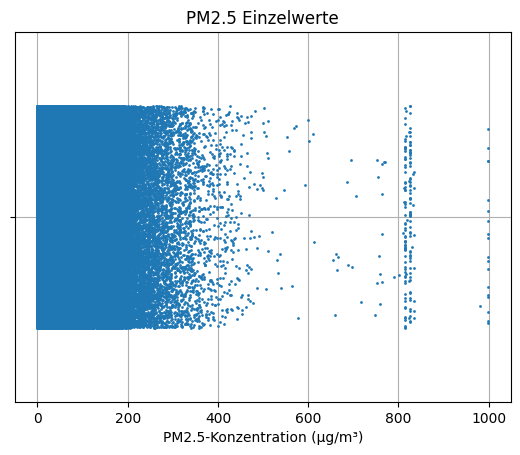

In [19]:
sns.stripplot(x=df["Pm25"], size=2, jitter=0.3)
plt.title("PM2.5 Einzelwerte")
plt.xlabel("PM2.5-Konzentration (µg/m³)")
plt.grid(True);

Es zeigen sich auffällige Punktelinien kurz über 800, die einen technischen Maximalwert bestimmter Messgeräte vermuten lassen.

Wo genau liegen diese Linien?

In [20]:
df["Pm25"].value_counts().sort_index(ascending=False).head(10)

Pm25
999.00    18
981.00     1
834.00     7
832.00     2
831.00     1
826.00     4
825.00    58
824.00     4
818.00     1
816.00     3
Name: count, dtype: int64

Bei der visuellen Analyse der PM2.5-Messwerte fällt eine ungewöhnliche Häufung im Bereich zwischen 814 und 834 µg/m³ auf, begleitet von vereinzelten extrem hohen Werten bei 981 und 999 µg/m³. Diese Werte liegen deutlich außerhalb des realistischen Messbereichs und deuten auf Messfehler, Platzhalterwerte oder systembedingte Übertragungsfehler hin. Um die Analyse nicht zu verzerren, werden daher alle PM2.5-Werte ab 814 µg/m³ ausgeschlossen:

In [21]:
# PM2.5 >= 814
df.loc[df["Pm25"] >= 814, "Pm25"] = np.nan

In [ ]:
# sns.histplot(df["Pm25"], bins=50)

In [22]:
mean_pm25 = df["Pm25"].mean()
median_pm25 = df["Pm25"].median()
skew_pm25 = skew(df["Pm25"].dropna())

print(f"Mittelwert (mean): {mean_pm25:.2f}")
print(f"Median:            {median_pm25:.2f}")
print(f"Schiefe (Skewness): {skew_pm25:.2f}")

Mittelwert (mean): 53.16
Median:            42.00
Schiefe (Skewness): 2.02


#### Verteilung der bereinigten PM2.5-Werte

Die PM2.5-Werte zeigen eine deutlich rechtsschiefe Verteilung. Der Mittelwert liegt bei 53,19 µg/m³, während der Median nur 42,00 µg/m³ beträgt. Zusätzlich ergibt die Berechnung der Schiefe (Skewness) einen Wert von 2,26, was auf eine starke Asymmetrie hindeutet.
Diese rechtsschiefe Verteilung bedeutet, dass der Großteil der Messwerte im unteren Bereich liegt, während einige wenige sehr hohe Werte den Mittelwert nach oben ziehen.

Um die Analyse nicht durch technisch bedingte Ausreißer zu verzerren, wurden alle PM2.5-Werte ab 814 µg/m³ ausgeschlossen, da sie deutlich außerhalb des natürlichen Messbereichs liegen und teilweise systematisch auftraten (Platzhalterwerte).

## 2.2 Große Feinstaubpartikel (PM10)

"Als Feinstaub (⁠PM10⁠) bezeichnet man Partikel mit einem aerodynamischen Durchmesser von weniger als 10 Mikrometer (µm). Der größte Teil der anthropogenen Feinstaubemissionen stammt aus Verbrennungsvorgängen (Kfz-Verkehr, Gebäudeheizung) und Produktionsprozessen inkl. Schüttgutumschlag. [...] Feinstaub wird nicht nur direkt emittiert (primäre Partikel) sondern bildet sich auch aus Vorläuferstoffen (unter anderem aus Schwefeldioxid, Stickstoffoxid und Ammoniak) in der Atmosphäre (sekundäre Partikel)." (https://www.umweltbundesamt.de/daten/luft/luftschadstoff-emissionen-in-deutschland/emission-von-feinstaub-der-partikelgroesse-pm10#was-ist-feinstaub)

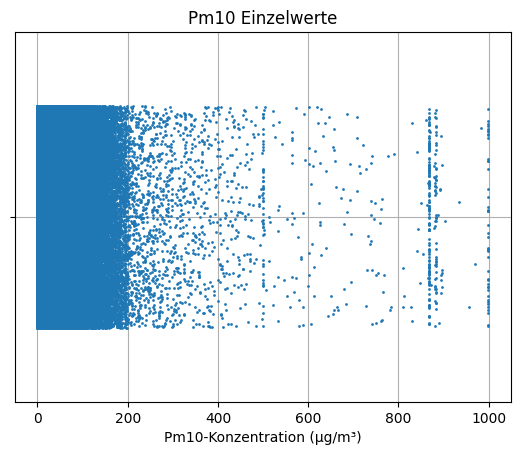

In [23]:
sns.stripplot(x=df["Pm10"], size=2, jitter=0.3)
plt.title("Pm10 Einzelwerte")
plt.xlabel("Pm10-Konzentration (µg/m³)")
plt.grid(True);

In [24]:
mean_pm10 = df["Pm10"].mean()
median_pm10 = df["Pm10"].median()
skew_pm10 = skew(df["Pm10"].dropna())

print(f"Mittelwert (mean): {mean_pm10:.2f}")
print(f"Median:            {median_pm10:.2f}")
print(f"Schiefe:           {skew_pm10:.2f}")

Mittelwert (mean): 27.07
Median:            19.00
Schiefe:           9.64


In [25]:
# Wo beginnt die Häufung bei der breiten Linie im Ausreißerbereich (ca. 820-840)?

df["Pm10"].value_counts().loc[lambda x: x.index > 850].sort_index()

Pm10
855.00     1
861.00     1
863.00     1
865.00     1
866.00     1
867.00    59
868.00    72
869.00     1
872.00     1
878.00     1
879.00     2
880.00    20
882.00    24
884.00    13
887.00     1
890.00     1
892.00     1
893.00     1
895.00     4
896.00     4
903.00     1
935.00     1
956.00     1
970.00     1
983.00     1
999.00    45
Name: count, dtype: int64

In [ ]:
# # "Datenmauer" plotten (Visualisierung der Häufung von Werten im Ausreißerbereich)

# high_values = df["Pm10"][df["Pm10"] > 800]
# sns.histplot(high_values, binwidth=1)
# plt.title("Häufigkeit der PM10-Werte > 800")
# plt.xlabel("PM10-Wert (µg/m³)")
# plt.ylabel("Anzahl")
# plt.grid(True)
# plt.show()

In [26]:
# PM10 >= 867
df.loc[df["Pm10"] >= 867, "Pm10"] = np.nan

#### Verteilung der bereinigten PM10-Werte
Die PM10-Werte zeigen eine deutlich rechtsschiefe Verteilung mit einem Mittelwert von 32.43 µg/m³, einem Median von 24.00 µg/m³ und einer Schiefe von 7.17. Der größte Teil der Messwerte liegt unterhalb von 200 µg/m³, mit einer kontinuierlich abnehmenden Dichte bis in den Bereich von ca. 850 µg/m³.

Eine detaillierte Analyse der Einzelwertverteilung ergab jedoch eine auffällige Häufung von Messwerten im Bereich 867–882 µg/m³, insbesondere 40 Messungen mit dem identischen Wert 867. Diese systematische Häufung spricht stark für einen technisch bedingten Fehler oder künstlich begrenzte Wertebereiche. Zusätzlich tritt 33 Mal der Platzhalterwert 999 auf.

Um die Analyse nicht durch diese systematischen Verzerrungen zu beeinflussen, wurden alle PM10-Werte ab 867 µg/m³ aus dem Datensatz ausgeschlossen.

## 2.3 Kohlenmonoxid (CO)

"Kohlenmonoxid (CO) ist ein farb-, geruch- und geschmackloses Gas, das bei der unvollständigen Verbrennung von Brenn- und Treibstoffen entsteht. Es bildet sich, wenn bei Verbrennungsprozessen zu wenig Sauerstoff zur Verfügung steht. In höheren Konzentrationen wirkt CO als starkes Atemgift." (https://www.umweltbundesamt.de/themen/luft/luftschadstoffe-im-ueberblick/kohlenmonoxid)

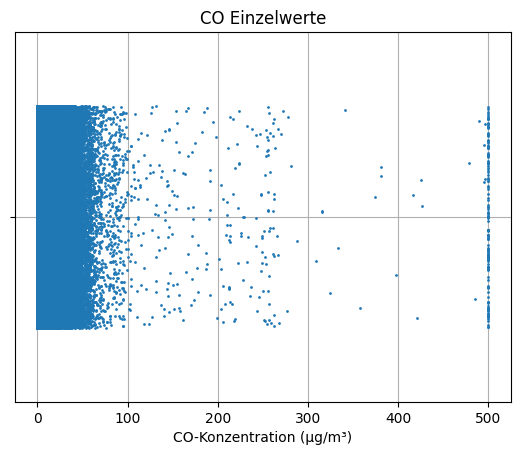

In [27]:
sns.stripplot(x=df["Co"], size=2, jitter=0.3)
plt.title("CO Einzelwerte")
plt.xlabel("CO-Konzentration (µg/m³)")
plt.grid(True);

In [28]:
mean_co = df["Co"].mean()
median_co = df["Co"].median()
skew_co = skew(df["Co"].dropna())

print(f"Mittelwert (mean): {mean_co:.2f}")
print(f"Median:            {median_co:.2f}")
print(f"Schiefe:           {skew_co:.2f}")

Mittelwert (mean): 4.77
Median:            3.40
Schiefe:           27.96


In [29]:
# CO > 300 oder CO == 500 → als NaN
df.loc[df["Co"] >= 300, "Co"] = np.nan

#### Verteilung der bereinigten CO-Werte

Die Verteilung der CO-Messwerte ist stark rechtsschief, mit einem Mittelwert von 4.74 µg/m³, einem Median von 3.40 µg/m³ und einer Schiefe von 29.64. Dies deutet auf extreme Ausreißer hin, die den Mittelwert erheblich verzerren. Zusätzlich tritt eine auffällige Häufung exakt bei 500 µg/m³ auf, was sehr wahrscheinlich ein technischer Platzhalterwert ist.

Um die Aussagekraft der Analyse zu erhöhen, wurden daher alle Werte ab 300 µg/m³ ausgeschlossen. Dieser Grenzwert liegt deutlich oberhalb der Hauptverteilung und entfernt technische Ausreißer, aber auch extreme realistische Einzelwerte.

## 2.4 Stickstoffdioxid (NO₂)

"Stickstoffdioxid (NO₂) ist ein ätzendes Reizgas, es schädigt unmittelbar das Schleimhautgewebe im gesamten Atemtrakt und kann auch die Augen reizen. Stickstoffdioxid zeigt eine stärkere schädliche Wirkung als Stickstoffmonoxid (NO), weshalb Stickstoffdioxid im Zentrum der Bemühungen um saubere Luft steht. [...] Die mittelbare Wirkung des Stickstoffdioxids auf die menschliche Gesundheit besteht in seiner Eigenschaft als Vorläufersubstanz für die Bildung von Feinstaub." (https://www.umweltbundesamt.de/service/uba-fragen/wie-wirken-sich-stickstoffoxide-auf-die-menschliche)

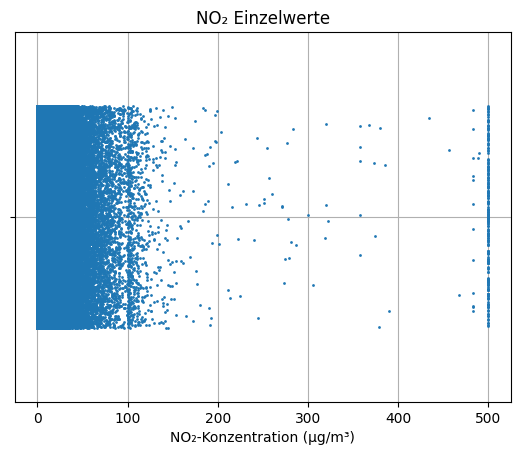

In [30]:
sns.stripplot(x=df["No2"], size=2, jitter=0.3)
plt.title("NO₂ Einzelwerte")
plt.xlabel("NO₂-Konzentration (µg/m³)")
plt.grid(True);

In [31]:
mean_no2 = df["No2"].mean()
median_no2 = df["No2"].median()
skew_no2 = skew(df["No2"].dropna())

print(f"Mittelwert (mean): {mean_no2:.2f}")
print(f"Median:            {median_no2:.2f}")
print(f"Schiefe:           {skew_no2:.2f}")

Mittelwert (mean): 9.76
Median:            7.50
Schiefe:           19.34


In [32]:
# NO2 >= 300 oder == 500
df.loc[df["No2"] >= 300, "No2"] = np.nan

#### Verteilung der bereinigten NO₂-Werte
Die NO₂-Werte zeigen eine stark rechtsschiefe Verteilung, mit einem Mittelwert von 10.55 µg/m³, einem Median von 8.40 µg/m³ und einer Schiefe von 10.08. Die große Mehrheit der Messwerte liegt unterhalb von 120 µg/m³, während einzelne Ausreißer bis 425 µg/m³ reichen. 

Zusätzlich tritt eine auffällige Häufung bei 500 µg/m³ auf, was sehr wahrscheinlich auf technische Platzhalterwerte zurückzuführen ist.

Um die Analyse nicht durch extreme Einzelwerte zu verzerren, wurden alle NO₂-Werte ab 300 µg/m³ ausgeschlossen.

## 2.5 Schwefeldioxid (SO₂)

"Schwefeldioxid (SO2) ist ein farbloses, stechend riechendes, wasserlösliches Gas, das Mensch und Umwelt beeinträchtigt. In der Atmosphäre aus Schwefeldioxid entstehende Sulfatpartikel tragen zudem zur Belastung mit Feinstaub (PM10) bei." (https://www.umweltbundesamt.de/themen/luft/luftschadstoffe-im-ueberblick/schwefeldioxid)

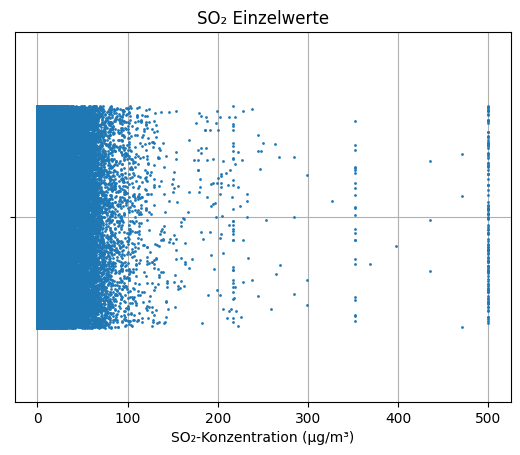

In [33]:
sns.stripplot(x=df["So2"], size=2, jitter=0.3)
plt.title("SO₂ Einzelwerte")
plt.xlabel("SO₂-Konzentration (µg/m³)")
plt.grid(True);

In [34]:
mean_so2 = df["So2"].mean()
median_so2 = df["So2"].median()
skew_so2 = skew(df["So2"].dropna())

print(f"Mittelwert (mean): {mean_so2:.2f}")
print(f"Median:            {median_so2:.2f}")
print(f"Schiefe:           {skew_so2:.2f}")

Mittelwert (mean): 3.98
Median:            2.50
Schiefe:           25.75


Es zeigt sich eine auffällige Punktelinie zwischen 300 und 400, die einen technischen Maximalwert bestimmter Messgeräte vermuten lässt.

Wo genau liegt diese Linie?

In [35]:
df["So2"].value_counts().sort_index(ascending=False).head(10)

So2
500.00    125
470.90      3
435.20      3
397.50      1
368.80      1
352.20     24
326.80      1
299.00      3
285.00      3
269.10      1
Name: count, dtype: int64

In [36]:
# SO2 >= 352 oder == 500
df.loc[df["So2"] >= 352, "So2"] = np.nan

#### Verteilung der bereinigten SO₂-Werte
Die Verteilung ist stark rechtsschief (Skewness = 25.75) mit einem Median von 2.5 µg/m³ und einem Mittelwert von 3.98 µg/m³.

Der Großteil der Werte liegt im Bereich von 0 bis 70 µg/m³, wobei sich oberhalb dieses Bereichs eine kontinuierlich abnehmende Streuung zeigt.

Ab etwa 220 µg/m³ tritt eine leichte Häufung auf, bei 352 µg/m³ eine weitere, und bei 500 µg/m³ zeigt sich eine deutliche Punktelinie – vermutlich ein technischer Maximalwert oder Platzhalter.

Zur Verbesserung der Datenqualität und Modellierbarkeit wurde ein Cutoff bei 352 µg/m³ gesetzt.
Alle Werte oberhalb dieses Grenzwerts wurden durch NaN ersetzt.

## 2.6 Ozon (O₃)

"Das farblose und giftige Gas Ozon ist eines der wichtigsten Spurengase in der Atmosphäre. [...] In Bodennähe auftretendes Ozon wird nicht direkt freigesetzt, sondern bei intensiver Sonneneinstrahlung durch komplexe photochemische Prozesse aus Vorläuferschadstoffen − überwiegend Stickstoffoxiden und flüchtigen organischen Verbindungen − gebildet. Ozon wird deshalb als sekundärer Schadstoff bezeichnet." (https://www.umweltbundesamt.de/themen/luft/luftschadstoffe-im-ueberblick/ozon)

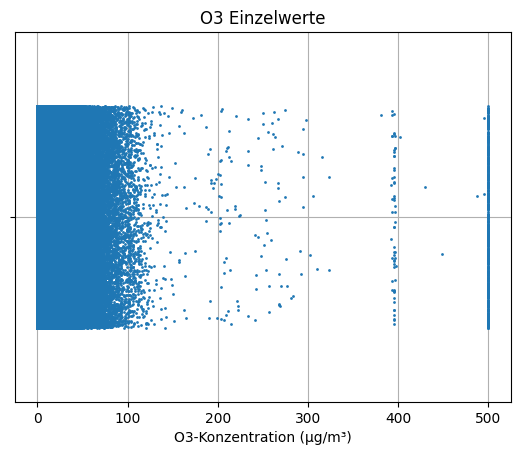

In [37]:
sns.stripplot(x=df["O3"], size=2, jitter=0.3)
plt.title("O3 Einzelwerte")
plt.xlabel("O3-Konzentration (µg/m³)")
plt.grid(True);

In [38]:
mean_o3 = df["O3"].mean()
median_o3 = df["O3"].median()
skew_o3 = skew(df["O3"].dropna())

print(f"Mittelwert (mean): {mean_o3:.2f}")
print(f"Median:            {median_o3:.2f}")
print(f"Schiefe:           {skew_o3:.2f}")

Mittelwert (mean): 20.46
Median:            19.90
Schiefe:           13.71


Es zeigt sich eine auffällige Punktelinie zwischen kurz unterhalb von 400, die einen technischen Maximalwert bestimmter Messgeräte vermuten lässt.

Wo genau liegt diese Linie?

In [39]:
df["O3"].value_counts().sort_index(ascending=False).head(20)

O3
500.00    536
495.00      1
494.90      1
487.10      1
448.40      1
429.60      1
402.00      1
397.80      1
397.00      1
396.40      8
395.00     36
393.70      9
393.60      1
392.30      2
381.00      1
323.50      2
315.50      1
309.90      1
306.00      1
302.50      1
Name: count, dtype: int64

In [40]:
# O3 >= 323.5 oder == 500
df.loc[df["O3"] >= 323.5, "O3"] = np.nan

#### Verteilung der bereinigten Ozon-Werte (O₃)
Die Ozonwerte (O3) zeigen eine stark rechtsschiefe Verteilung mit einer Skewness von 13.71. Der Median liegt bei 19.90 µg/m³, der Mittelwert bei 20.46 µg/m³ – was nahe beieinander liegt, aber durch einige hohe Ausreißer leicht verzerrt wird.

Im oberen Bereich der Verteilung ist eine ausgeprägte Punktelinie bei 395 µg/m³ erkennbar, mit 36 identischen Messwerten. Zudem zeigt sich eine große Häufung bei 500 µg/m³ mit 536 Einträgen – ein starkes Indiz für technische Grenzwerte oder Platzhalterwerte.

Zwischen 323.5 µg/m³ und 381 µg/m³ besteht eine auffällige Lücke, was darauf hinweist, dass oberhalb von 323.5 keine kontinuierliche natürliche Streuung mehr vorhanden ist.

Es wurde ein Cutoff bei 323.5 µg/m³ gesetzt. Alle Werte oberhalb dieses Grenzwerts wurden durch NaN ersetzt.

## 2.7 Tabelle zur Anzahl der entfernten Werte pro Spalte

In [41]:
missing_after = df.isna().sum()
outliers_removed = missing_after - missing_before

outlier_table = pd.DataFrame({
    "Missing Before": missing_before,
    "Missing After": missing_after,
    "Outliers Replaced": missing_after - missing_before
})

# Nur Zeilen anzeigen, in denen tatsächlich Ausreißer ersetzt wurden - alos die Schadstoff-Spalten
outlier_table_filtered = outlier_table[outlier_table["Outliers Replaced"] != 0]

outlier_table_filtered

,Missing Before,Missing After,Outliers Replaced
Co,631810,631968,158
No2,286260,286514,254
O3,374148,374751,603
Pm10,341852,342107,255
Pm25,262789,262950,161
So2,532975,533132,157


In [42]:
# Wieviele Daten (%) wurden durch Ausreißerentfernung verloren?
missing_before_total = missing_before.sum()
missing_after_total = missing_after.sum()
outliers_total = missing_after_total - missing_before_total
outlier_percent = outliers_total / total_values_before * 100

print(f"Anzahl ersetzter Ausreißer: {outliers_total:,}")
print(f"Prozentualer Anteil der ersetzten Ausreißer: {outlier_percent:.4f}%")

Anzahl ersetzter Ausreißer: 1,588
Prozentualer Anteil der ersetzten Ausreißer: 0.0041%


Durch das Entfernen klar identifizierter Ausreißer **in den Schadstoffvariablen** wurden lediglich 0.0041 % der Datenpunkte ersetzt.
Der Datensatz wurde dadurch kaum reduziert, ist aber nun robuster gegenüber Verzerrungen, was insbesondere für Machine-Learning-Modelle, aber auch für Visualisierungen von Vorteil ist.

# 3. Deskriptive Statistik & Ausreißer-Handling: Wetter

Analog zum Vorgehen bei den Schadstoffen werden im Folgenden alle Wettervariablen untersucht und ggf. Platzhalterwerte und starke Ausreißer durch NaN ersetzt.

Die Wettervariablen werden in einer Schleife am Stück abgehandelt. Da das Setzen der Grenzwerte und das Entfernen von Ausreißern für jede Variable individuell entscheiden werden sollte, um möglichst alle realistischen Werte zu erhalten, wird dieser Schritt nachgelagert.

In [43]:
# Save percentage of missing values AFTER manipulation pollutants and BEFORE manipulating weather data
missing_before_weather = df.isna().sum()
total_values_before_weather = df.shape[0] * df.shape[1]

In [44]:
df[["Tavg", "Tmin", "Tmax", "Humidity", "Wspd", "Wdir", "Pres", "Prcp", "Dew"]].describe()


,Tavg,Tmin,Tmax,Humidity,Wspd,Wdir,Pres,Prcp,Dew
count,"1,403,687.00","1,378,595.00","1,376,836.00","1,306,961.00","1,240,293.00","1,170,876.00","1,204,252.00","1,041,250.00","1,000,165.00"
mean,15.38,10.82,20.39,68.66,11.34,183.56,"1,015.15",2.98,9.69
std,9.53,9.38,10.20,23.91,6.24,106.94,8.12,9.00,9.59
min,-41.00,-46.00,-37.20,"-2,671.10",0.00,0.00,925.20,0.00,-64.30
25%,8.70,4.30,13.10,58.30,7.00,86.00,"1,010.00",0.00,3.00
50%,15.90,11.00,21.10,72.80,10.00,194.00,"1,015.00",0.00,10.00
75%,22.70,17.70,28.30,83.00,14.20,275.00,"1,020.30",1.70,16.60
max,44.80,39.00,87.00,999.90,176.30,360.00,"1,392.10",462.00,32.00


#### Tabellarische Auswertung von describe()

| Spalte | Bedingung für NaN                     | Begründung |
|:-------|:--------------------------------------|:-----------|
|Tavg    |                                       |plausible Verteilung, visuell prüfen |
|Tmin    |                                       |plausible Verteilung, visuell prüfen |
|Tmax	 |Tmax > 60	                             |gemessenes Maximum weit über weltweit beobachtete Temperaturen |
|Humidity|Humidity < 0 oder > 100                |physikalisch unmöglich / Platzhalter |
|Wspd	 |erst visuell prüfen, dann ggf. > 150   |Hurrikan-Grenze, höhere Werte für einzelen Böen möglich aber selten |
|Wdir    |<0 oder >360                           |Windrichtung wird in Winkelgrad gemessen |
|Pres	 |Pres > 1100	                         |Maximum ungewöhnlich hoch, Messfehler möglich |
|Prcp	 |                                       |plausible Verteilung, visuell prüfen |
|Dew	 |ggf. ab –70 prüfen                     |tendenziell realistisch, vorsichtiger Umgang  |



📊 Analyse für: Tavg


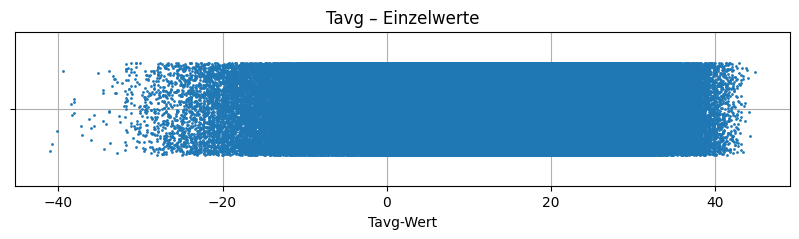

Mean:   15.38
Median: 15.90
Skew:   -0.38
Min:    -41.00
Max:    44.80
99.9%-Quantil (statistical suggestion only!): 38.30

📊 Analyse für: Tmin


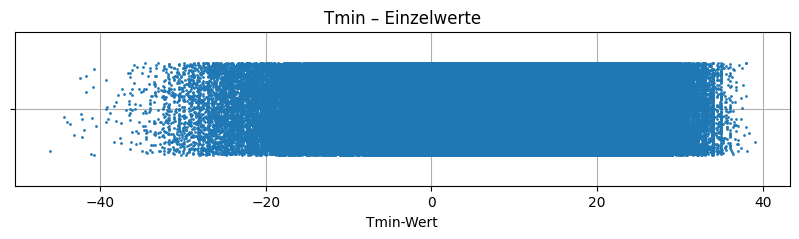

Mean:   10.82
Median: 11.00
Skew:   -0.32
Min:    -46.00
Max:    39.00
99.9%-Quantil (statistical suggestion only!): 32.40

📊 Analyse für: Tmax


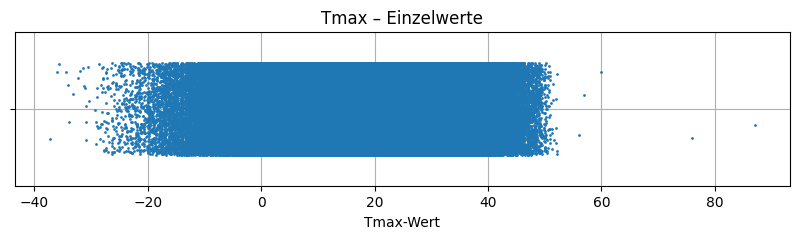

Mean:   20.39
Median: 21.10
Skew:   -0.37
Min:    -37.20
Max:    87.00
99.9%-Quantil (statistical suggestion only!): 45.90

📊 Analyse für: Humidity


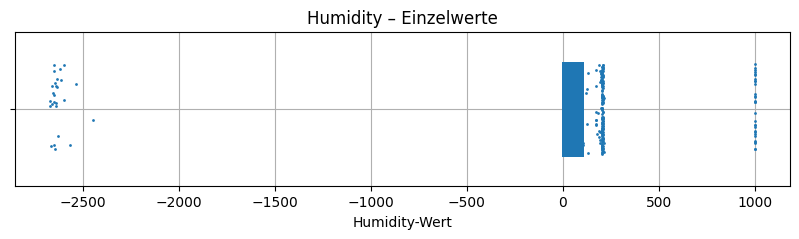

Mean:   68.66
Median: 72.80
Skew:   -27.84
Min:    -2671.10
Max:    999.90
99.9%-Quantil (statistical suggestion only!): 100.00

📊 Analyse für: Wspd


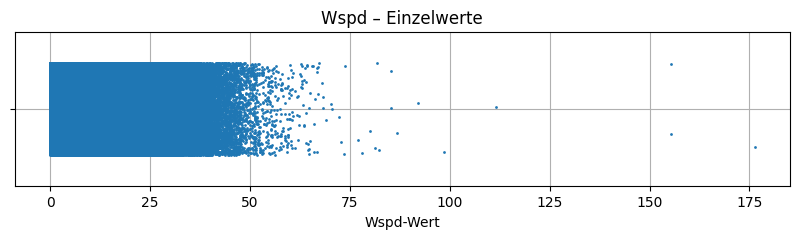

Mean:   11.34
Median: 10.00
Skew:   1.51
Min:    0.00
Max:    176.30
99.9%-Quantil (statistical suggestion only!): 44.70

📊 Analyse für: Wdir


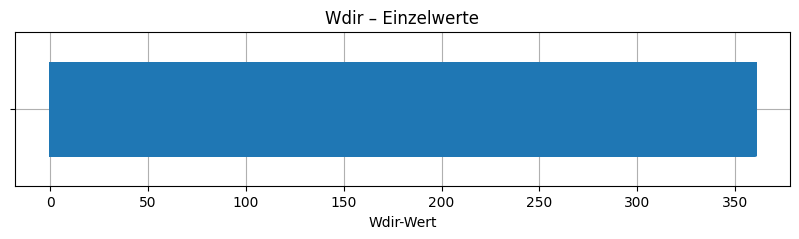

Mean:   183.56
Median: 194.00
Skew:   -0.11
Min:    0.00
Max:    360.00
99.9%-Quantil (statistical suggestion only!): 359.00

📊 Analyse für: Pres


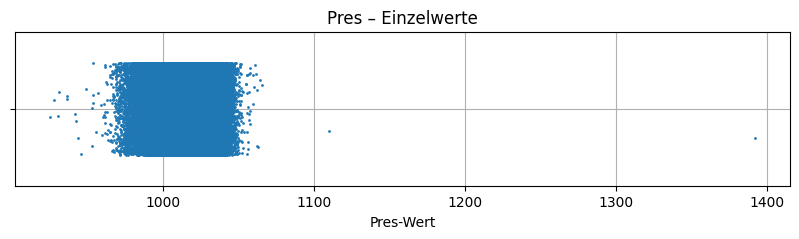

Mean:   1015.15
Median: 1015.00
Skew:   -0.04
Min:    925.20
Max:    1392.10
99.9%-Quantil (statistical suggestion only!): 1041.70

📊 Analyse für: Prcp


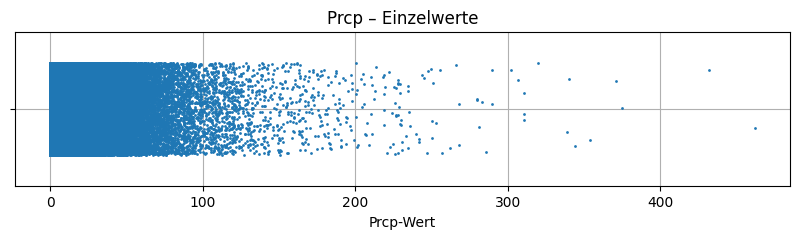

Mean:   2.98
Median: 0.00
Skew:   8.19
Min:    0.00
Max:    462.00
99.9%-Quantil (statistical suggestion only!): 101.10

📊 Analyse für: Dew


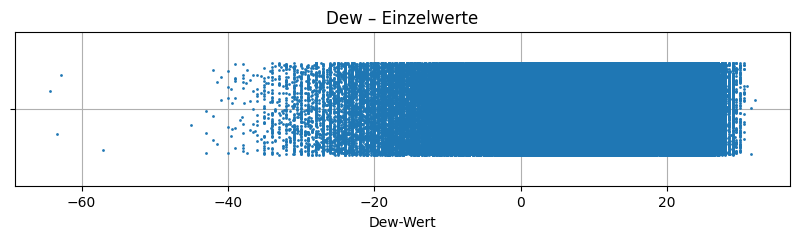

Mean:   9.69
Median: 10.00
Skew:   -0.37
Min:    -64.30
Max:    32.00
99.9%-Quantil (statistical suggestion only!): 28.00


In [45]:
# Schleife für Wettervariablen

weather_columns = ["Tavg", "Tmin", "Tmax", "Humidity", "Wspd", "Wdir", "Pres", "Prcp", "Dew"]

for col in weather_columns:
    print(f"\n📊 Analyse für: {col}")
    
    # Stripplot
    plt.figure(figsize=(10, 2))
    sns.stripplot(x=df[col], size=2, jitter=0.3)
    plt.title(f"{col} – Einzelwerte")
    plt.grid(True)
    plt.xlabel(f"{col}-Wert")
    plt.show()
    
    # Statistische Kennzahlen
    mean_val = df[col].mean()
    median_val = df[col].median()
    skew_val = df[col].skew()
    min_val = df[col].min()
    max_val = df[col].max()
    
    print(f"Mean:   {mean_val:.2f}")
    print(f"Median: {median_val:.2f}")
    print(f"Skew:   {skew_val:.2f}")
    print(f"Min:    {min_val:.2f}")
    print(f"Max:    {max_val:.2f}")
    
    # Cutoff-Vorschlag (nur zur Orientierung)
    cutoff = df[col].quantile(0.999)
    print(f"99.9%-Quantil (statistical suggestion only!): {cutoff:.2f}")


### Cutoffbestimmung und Ausreißerentfernung für Wettervariablen

Für die beiden Variablen, bei denen der Stripplot keine eindeutige Auskunft gibt (Tmax und Dew), wird der Cutoff-Wert durch einen Blick auf die betreffenden Messwerte bestimmt:

In [46]:
# Cutoff für Tmax genauer bestimmen; oberste 10 Messwerte anschauen:

df["Tmax"].value_counts().sort_index(ascending=False).head(10)

# --> Cutoff bei 60 Grad

Tmax
87.00    1
76.00    1
60.00    1
57.00    1
56.00    1
52.20    1
52.10    2
52.00    3
51.70    1
51.50    2
Name: count, dtype: int64

In [47]:
# Wie entsteht der "gestrichelte" Eindruck im Stripplot für den Taupunkt? Gibt es mehrhheitlich ganzzahlige Messwerte?
df["Dew"].dropna().apply(lambda x: x.is_integer()).value_counts()

# --> Vermutlich geben die meisten Messgeräte nur ganzzahlige Werte aus

Dew
True     642772
False    357393
Name: count, dtype: int64

In [48]:
# Ausreißerentfernung für alle Wettervariablen, bei denen die Stripplots Ausreißer zeigen

# Tmax: realistische Obergrenze bei 60°C
df.loc[df["Tmax"] > 60, "Tmax"] = np.nan

# Humidity: alles < 0 oder > 100 ist physikalisch nicht (bzw. über 100% nur SEHR kurzzeitig) möglich
df.loc[(df["Humidity"] < 0) | (df["Humidity"] > 100), "Humidity"] = np.nan

# Wspd: Werte > 150 km/h (Orkangrenze) sind extrem selten
df.loc[df["Wspd"] > 150, "Wspd"] = np.nan

# Pres: zwei Ausreißer über 1100 hPa, vermutlich technisches Problem
df.loc[df["Pres"] > 1100, "Pres"] = np.nan

# Prcp: 2 extreme Ausreißer, im Prinzip möglich, aber für Modelle ungünstig und für den Gesamtdatensatz nicht repräsentativ
df.loc[df["Prcp"] > 400, "Prcp"] = np.nan

# Dew: Werte von -40 bis 32 sind zu erwarten; mit diesen Schwellenwerten werden nur wenige Extremwerte entfernt
df.loc[(df["Dew"] < -40) | (df["Dew"] > 32), "Dew"] = np.nan

### Verteilungen in den bereinigten Wettervariablen

🌡️ Tavg – Durchschnittstemperatur

Die Variable Tavg beschreibt die durchschnittliche tägliche Temperatur. Die Verteilung ist leicht linksschief mit einem Skewness-Wert von –0.38. Der Mittelwert beträgt 15.38 °C, der Median liegt bei 15.90 °C, was auf eine weitgehend symmetrische Verteilung mit leichtem Übergewicht kälterer Temperaturen hinweist.

Ein Blick auf den Stripplot zeigt, dass sich alle Werte im realistisch meteorologischen Bereich befinden:

- Das Minimum liegt bei ca. –42 °C, was in sehr kalten Regionen (z. B. in Sibirien oder Teilen Kanadas) durchaus auftreten kann.
- Das Maximum liegt bei ca. 50 °C, was mit bekannten Hitzerekorden weltweit vereinbar ist.

Das 99.9%-Quantil liegt bei 38.30 °C. Dennoch wurde bewusst kein Grenzwert (Cutoff) gesetzt, da keine eindeutig unrealistischen Ausreißer erkennbar sind.

→ Es wurden keine Werte entfernt oder als Ausreißer markiert.

---

🌡️ Tmin – Tagestiefsttemperatur

Die Variable Tmin beschreibt die tägliche Tiefsttemperatur. Die Verteilung zeigt mit einer Schiefe von –0.32 eine leichte Linksschiefe, was auf ein geringfügiges Übergewicht sehr kalter Tage hinweist.
Der Mittelwert beträgt 10.82 °C, der Median 11.00 °C, was auf eine insgesamt symmetrische Verteilung ohne nennenswerte Verzerrungen schließen lässt.

Der Stripplot zeigt eine natürliche, kontinuierliche Verteilung der Messwerte.

- Das Minimum liegt bei –46 °C, was in kalten Klimazonen realistisch ist.
- Das Maximum bei 39 °C ist ungewöhnlich hoch für eine Tiefsttemperatur, aber unter besonderen Bedingungen (z. B. Hitzewellen) möglich.
- Das 99.9%-Quantil liegt bei 32.4 °C, wodurch nur sehr wenige extrem hohe Werte überhaupt betroffen wären.

Insgesamt zeigen sich keine auffälligen Ausreißer oder technische Artefakte.

→ Es wurden keine Werte entfernt oder ersetzt.

---

🌡️ Tmax – Tageshöchsttemperatur

Die Variable Tmax beschreibt die tägliche Höchsttemperatur.
Die Verteilung ist mit einem Skewness-Wert von –0.37 leicht linksschief.
Der Mittelwert beträgt 20.38 °C, der Median liegt bei 21.10 °C – die Verteilung ist insgesamt gut balanciert.

Der Stripplot zeigt einen realistischen Verlauf im Bereich zwischen ca. –37 °C und 50 °C, wobei sich oberhalb von 50 °C vereinzelte Werte häufen. Eine genauere Prüfung der 20 höchsten Werte ergab jedoch drei offensichtliche Ausreißer:
→ 60 °C, 76 °C und 87 °C – allesamt deutlich über bekannten meteorologischen Rekorden.

→ Als Grenzwert wurde daher ein Cutoff bei 60 °C gesetzt. Drei Werte oberhalb dieses Grenzwerts wurden durch NaN ersetzt.

---

💧 Humidity – Relative Luftfeuchtigkeit

Die Variable Humidity beschreibt die relative Luftfeuchtigkeit in Prozent.
Die Verteilung ist extrem linksschief mit einer Skewness von –27.84, was auf starke Ausreißer im negativen und sehr hohen Bereich hindeutet.

Die realistischen Messwerte liegen zwischen 0 % und 100 %.
Der Stripplot zeigt jedoch vereinzelte, stark auffällige Werte:

- Das Minimum beträgt –2671.1 %, was physikalisch unmöglich ist
- Das Maximum liegt bei 999.9 %, höchstwahrscheinlich ein Platzhalterwert

→ Es wurde daher ein Grenzbereich von 0 % bis 100 % definiert. Alle Werte außerhalb dieses Intervalls wurden durch NaN ersetzt.

---

💨 Wspd – Windgeschwindigkeit

Die Variable Wspd beschreibt die tägliche durchschnittliche Windgeschwindigkeit in km/h.
Die Verteilung zeigt eine leichte Rechtsschiefe mit einem Skewness-Wert von 1.51.
Der Mittelwert liegt bei 11.34 km/h, der Median bei 10.00 km/h, was auf einen leicht asymmetrischen, aber plausiblen Verlauf hindeutet.

Der Stripplot zeigt, dass die meisten Messwerte zwischen 0 und 45 km/h liegen, mit ausdünnender Streuung nach oben – was meteorologisch zu erwarten ist.
Drei auffällige Extremwerte oberhalb von 150 km/h wurden identifiziert, der Maximalwert liegt bei 176.3 km/h. Solche Werte sind theoretisch möglich (z. B. bei Orkanen), aber im Kontext dieser Analyse nicht repräsentativ.

→ Es wurde ein Cutoff bei 150 km/h gesetzt. Drei Werte oberhalb dieses Grenzwerts wurden durch NaN ersetzt.

---

🌬️ Pres – Luftdruck

Die Variable Pres beschreibt den täglichen Luftdruck in hPa. Die Verteilung ist mit einer Skewness von –0.04 nahezu symmetrisch, was auf eine ausgewogene, realistische Verteilung hinweist.
Der Mittelwert liegt bei 1015.15 hPa, was nahe am physikalischen Normaldruck (1013 hPa) liegt.

Ein Blick auf die Extremwerte zeigt:

- Minimum: 925.2 hPa – plausibel, z. B. bei Tiefdrucklagen
- Maximum: 1392.1 hPa – stark unrealistisch, deutlich über bekannten Rekorden

→ Es wurde ein Cutoff bei 1100 hPa gesetzt. Zwei klare Ausreißer oberhalb dieses Grenzwerts wurden durch NaN ersetzt.

---

🌧️ Prcp – Niederschlag

Die Variable Prcp beschreibt die tägliche Niederschlagsmenge in mm. Die Verteilung ist mit einer Skewness von 8.21 stark rechtsschief:

- An über der Hälfte aller Tage wurde kein Niederschlag gemessen (Median: 0.0 mm).
- Einzelne Starkregenereignisse führen zu hohen Maximalwerten (bis zu 462 mm), die jedoch extrem selten sind.

→ Zur Vermeidung einer übermäßigen Verzerrung der Analyse wurde ein Cutoff bei 400 mm gesetzt. Zwei ungewöhnlich hohe Werte oberhalb dieses Grenzwerts wurden durch NaN ersetzt.

---

💧 Dew – Taupunkt

Die Variable Dew beschreibt den täglichen Taupunkt in °C – also die Temperatur, bei der die Luft mit Wasserdampf gesättigt ist.
Die Werte zeigen eine leicht linksschiefe Verteilung mit einer Skewness von –0.37.
Mittelwert und Median liegen nahe beieinander (9.69 °C bzw. 10.00 °C), was auf eine insgesamt ausgewogene Verteilung hindeutet.

Der Stripplot vermittelt einen „gestückelten“ Eindruck, da etwa zwei Drittel der Werte ganzzahlig sind – vermutlich durch vorverarbeitete oder gerundete Messdaten. Ein gutes Drittel liegt jedoch im nicht-ganzzahligen Bereich, was unterschiedliche Genauigkeitsstufen in den Datenquellen vermuten lässt.

Zur Erkennung potenzieller Ausreißer wurden die physikalisch plausiblen Grenzwerte des Taupunkts berücksichtigt:

- Oberhalb von 32 °C (tropisch-feucht) und
- Unterhalb von –40 °C (polar-trocken) sind reale Messwerte zwar nicht unmöglich, aber extrem selten.

→ Es wurde ein Cutoff bei –40 °C und +32 °C gesetzt. Werte außerhalb dieses Bereichs wurden durch NaN ersetzt.


### Tabelle zur Anzahl der entfernten Werte pro Spalte (Wetter)

In [49]:
missing_after_weather = df.isna().sum()
outliers_weather = missing_after_weather - missing_before_weather

outlier_weather_table = pd.DataFrame({
    "Missing Before": missing_before_weather,
    "Missing After": missing_after_weather,
    "Outliers Replaced": outliers_weather
})

# Nur Zeilen anzeigen, in denen tatsächlich Ausreißer ersetzt wurden - alos die Schadstoff-Spalten
outlier_weather_table_filtered = outlier_weather_table[outlier_weather_table["Outliers Replaced"] != 0]

outlier_weather_table_filtered

,Missing Before,Missing After,Outliers Replaced
Dew,694876,694891,15
Humidity,388080,388414,334
Tmax,318205,318207,2
Prcp,653791,653793,2
Wspd,454748,454751,3
Pres,490789,490791,2


In [50]:
missing_before_total_weather = missing_before_weather.sum()
missing_after_total_weather = missing_after_weather.sum()
outliers_total_weather = missing_after_total_weather - missing_before_total_weather
outlier_percent_weather = outliers_total_weather / total_values_before_weather * 100

print(f"Anzahl ersetzter Ausreißer (Wetterdaten): {outliers_total_weather:,}")
print(f"Prozentualer Anteil der ersetzten Ausreißer: {outlier_percent_weather:.4f}%")


Anzahl ersetzter Ausreißer (Wetterdaten): 358
Prozentualer Anteil der ersetzten Ausreißer: 0.0009%


Durch das Entfernen klar identifizierter Ausreißer **in den Wettervariablen** wurden lediglich 0.0009 % der Datenpunkte ersetzt. Der Datensatz wurde dadurch kaum reduziert, ist aber nun robuster gegenüber Verzerrungen, was insbesondere für Machine-Learning-Modelle von Vorteil ist.

Da die Ausreißer nur aus den betreffenden **Zellen** gelöscht wurden, hat sich der Gesamtumfang des Datensatzes durch die Ausreißerentfernung noch nicht verändert.

Der Umgang mit NaN-Werten (Entfernung, Imputation) ist nicht mehr Teil dieses Notebooks, weil die Entscheidung. wie mit den NaN-Werten verfahren wird, von der Art der angestrebten Analyse abhängt und daher erst dort getroffen werden sollte.

# 4. Speichern des um Ausreißer bereinigten Datensatzes

In [ ]:
# define today's date
datum = date.today().isoformat()

# Ordnerpfad (z. B. "C:/Daten" unter Windows oder "/home/user/Daten" unter Linux/Mac)
ordner = "../air_quality/data"
 
# Vollständiger Dateipfad
dateipfad = os.path.join(ordner, f"cleaned_air_quality_data_{datum}.csv")
 
# DataFrame als CSV speichern
df.to_csv(dateipfad, index=False, encoding="utf-8")
print(f"CSV-Datei wurde in '{dateipfad}' gespeichert.")
 

CSV-Datei wurde in '../air_quality/data/cleaned_air_quality_data_2025-04-24.csv' gespeichert.
